In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **LOAD & CHECK DATA**

In [2]:
import warnings
warnings.filterwarnings("ignore")
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
from PIL import Image
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords


In [3]:
books=pd.read_csv("Books.csv")
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [4]:
ratings=pd.read_csv("Ratings.csv")
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [5]:
users=pd.read_csv("Users.csv")
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [6]:
print("Books Shape: " ,books.shape )
print("Ratings Shape: " ,ratings.shape )
print("Users Shape: " ,users.shape )

Books Shape:  (271360, 8)
Ratings Shape:  (1149780, 3)
Users Shape:  (278858, 3)


In [7]:
print("Any null values in Books:\n" ,books.isnull().sum())
print("Any null values in Ratings:\n ",ratings.isnull().sum())
print("Any null values in Users:\n",users.isnull().sum())

Any null values in Books:
 ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Any null values in Ratings:
  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
Any null values in Users:
 User-ID          0
Location         0
Age         110762
dtype: int64


# **PREPROCESSING**

In [8]:
books_data=books.merge(ratings,on="ISBN")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [9]:
df=books_data.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"],axis=1,inplace=True)
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.head()

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,123629,9


# **POPULARITY BASED RECOMMENDATION SYSTEM**

* Popularity based recommendation systems are based on the rating of items by all the users.
* Popularity based recommendation systems works with the trend. It basically uses the items which are in trend right now.

In [10]:
def popular_books(df,n=100):
    rating_count=df.groupby("Book-Title").count()["Book-Rating"].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"},inplace=True)
    
    rating_average=df.groupby("Book-Title")["Book-Rating"].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"},inplace=True)
    
    popularBooks=rating_count.merge(rating_average,on="Book-Title")
    
    def weighted_rate(x):
        v=x["NumberOfVotes"]
        R=x["AverageRatings"]
        
        return ((v*R) + (m*C)) / (v+m)
    
    C=popularBooks["AverageRatings"].mean()
    m=popularBooks["NumberOfVotes"].quantile(0.90)
    
    popularBooks=popularBooks[popularBooks["NumberOfVotes"] >=250]
    popularBooks["Popularity"]=popularBooks.apply(weighted_rate,axis=1)
    popularBooks=popularBooks.sort_values(by="Popularity",ascending=False)
    return popularBooks[["Book-Title","NumberOfVotes","AverageRatings","Popularity"]].reset_index(drop=True).head(n)

TypeError: 'str' object is not callable

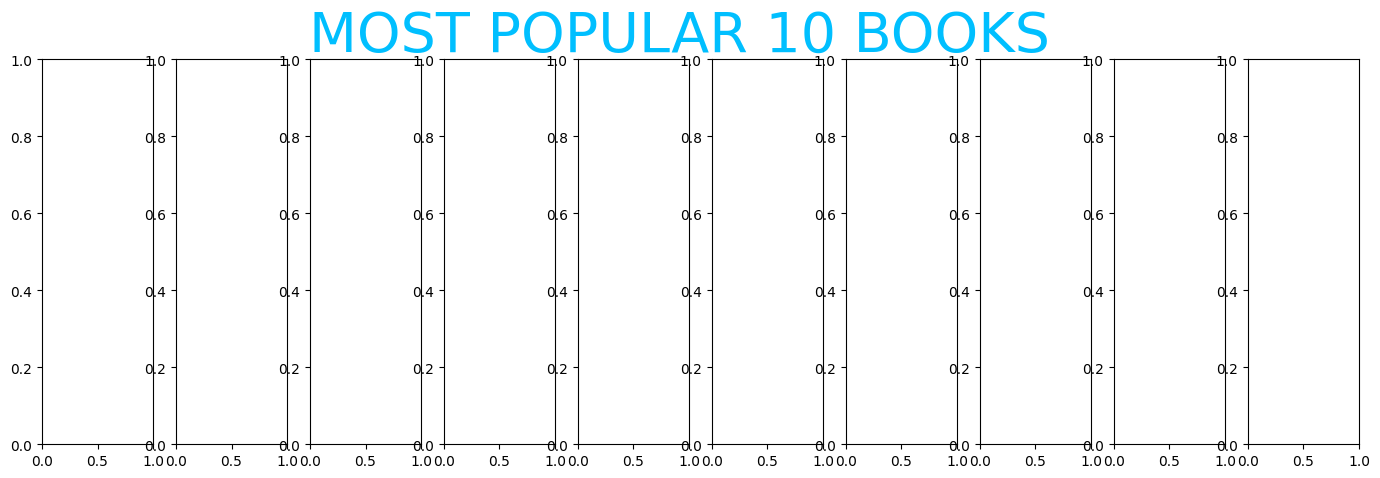

In [12]:
n=10
top_ten=pd.DataFrame(popular_books(df,10))
fig,ax=plt.subplots(1,10,figsize=(17,5))
fig.suptitle("MOST POPULAR 10 BOOKS",fontsize=40,color="deepskyblue")
for i in range(len(top_ten["Book-Title"].tolist())):
    url=df.loc[df["Book-Title"]==top_ten["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    img=Image.open(requests.get(url,stream=True).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==top_ten["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=10)
    fig.show()

# **ITEM-BASED COLLABORATIVE FILTERING**

In [ ]:
def item_based(bookTitle):
    bookTitle=str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=200].index
        common_books=df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books_pivot=common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
            title=common_books_pivot[bookTitle]
            recommendation_df=pd.DataFrame(common_books_pivot.corrwith(title).sort_values(ascending=False)).reset_index(drop=False)
            
            if bookTitle in [title for title in recommendation_df["Book-Title"]]:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==bookTitle].index[0])
                
            less_rating=[]
            for i in recommendation_df["Book-Title"]:
                if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]
                
            recommendation_df=recommendation_df[0:5]
            recommendation_df.columns=["Book-Title","Correlation"]
            
            fig, ax = plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("WOULD YOU LIKE to TRY THESE BOOKS?",fontsize=40,color="deepskyblue")
            for i in range(len(recommendation_df["Book-Title"].tolist())):
                url=df.loc[df["Book-Title"]==recommendation_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==recommendation_df["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()
    else:
        print("❌ COULD NOT FIND ❌")

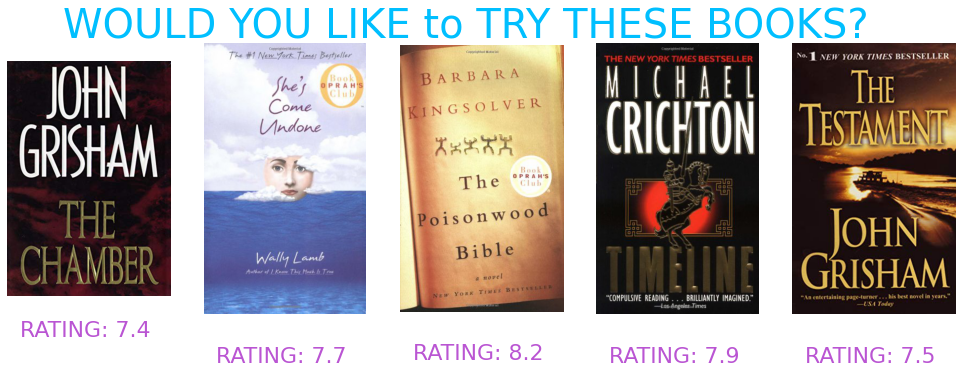

In [ ]:
item_based("Me Talk Pretty One Day")

In [ ]:
item_based("From One to One Hundred")

No Recommendations for this Book ☹️ 
 
YOU MAY TRY: 
 
Timeline 

Where the Heart Is Oprah s Book Club Paperback 

To Kill a Mockingbird 



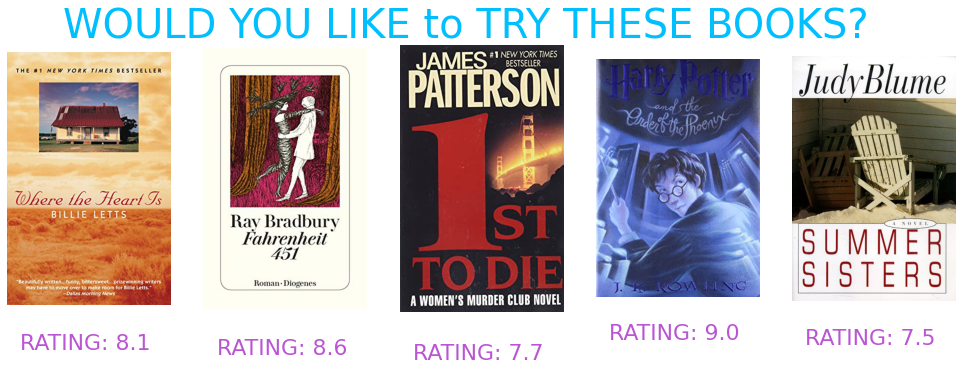

In [ ]:
item_based("The Da Vinci Code")

In [ ]:
item_based("Barbie")

❌ COULD NOT FIND ❌


# **USER-BASED COLLABORATIVE FILTERING**

In [ ]:
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 200]  # Drop users who vote less than 200 times.
users_pivot=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_pivot.fillna(0,inplace=True)

In [ ]:
def users_choice(id):
    
    users_fav=new_df[new_df["User-ID"]==id].sort_values(["Book-Rating"],ascending=False)[0:5]
    return users_fav

In [ ]:
def user_based(new_df,id):
    if id not in new_df["User-ID"].values:
        print("❌ User NOT FOUND ❌")
        
        
    else:
        index=np.where(users_pivot.index==id)[0][0]
        similarity=cosine_similarity(users_pivot)
        similar_users=list(enumerate(similarity[index]))
        similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]
    
        user_rec=[]
    
        for i in similar_users:
                data=df[df["User-ID"]==users_pivot.index[i[0]]]
                user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))
        
    return user_rec

In [ ]:
def common(new_df,user,user_id):
    x=new_df[new_df["User-ID"]==user_id]
    recommend_books=[]
    user=list(user)
    for i in user:
        y=new_df[(new_df["User-ID"]==i)]
        books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
        books=books.sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(books["Book-Title"].values)
        
    return recommend_books[0:5]

🟦 USER: 31556 


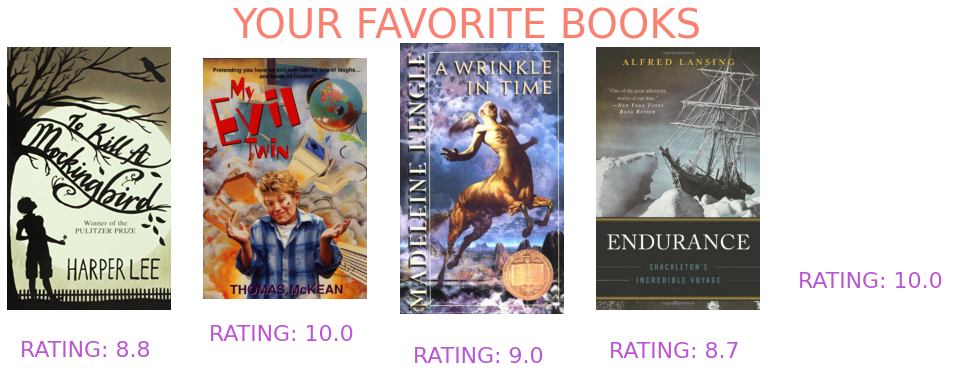

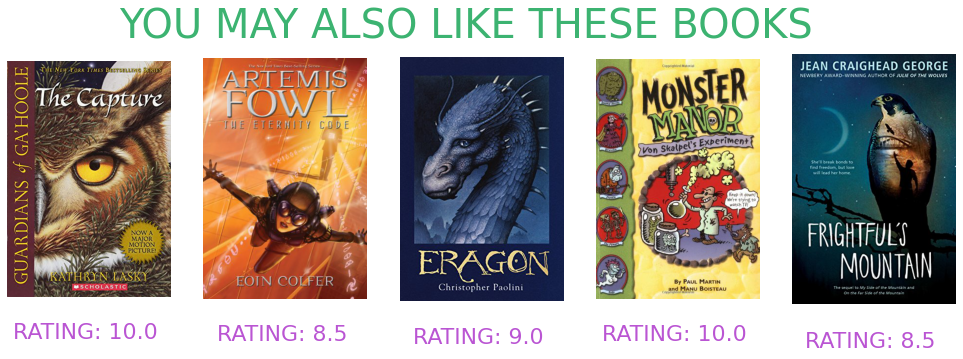

In [ ]:
user_id=random.choice(new_df["User-ID"].values)
user_choice_df=pd.DataFrame(users_choice(user_id))
user_favorite=users_choice(user_id)
n=len(user_choice_df["Book-Title"].values)
print("🟦 USER: {} ".format(user_id))
    
fig,ax=plt.subplots(1,n,figsize=(17,5))
fig.suptitle("YOUR FAVORITE BOOKS",fontsize=40,color="salmon")
    
for i in range(n):
        url=new_df.loc[new_df["Book-Title"]==user_choice_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
        img=Image.open(requests.get(url,stream=True).raw)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("RATING: {} ".format(round(new_df[new_df["Book-Title"]==user_choice_df["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
        fig.show()

user_based_rec=user_based(new_df,user_id)
books_for_user=common(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["Book-Title"])

fig,ax=plt.subplots(1,5,figsize=(17,5))
fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="mediumseagreen")
for i in range(5):
    url=new_df.loc[new_df["Book-Title"]==books_for_userDF["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    img=Image.open(requests.get(url,stream=True).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("RATING: {} ".format(round(new_df[new_df["Book-Title"]==books_for_userDF["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
    fig.show()

# **CONTENT-BASED COLLABORATIVE FILTERING** 

In [ ]:
def content_based(bookTitle):
    bookTitle=str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=200].index
        common_books=df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"]=[i for i in range(common_books.shape[0])]
            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])
            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["Book-Title"]==bookTitle]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            books=[]
            for i in range(len(similar_booksSorted)):
                
                books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())
            fig,ax=plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="chocolate")
                
            for i in range(len(books)):
                
                url=common_books.loc[common_books["Book-Title"]==books[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {}".format(round(df[df["Book-Title"]==books[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()

    else:
        print("❌ COULD NOT FIND ❌")               

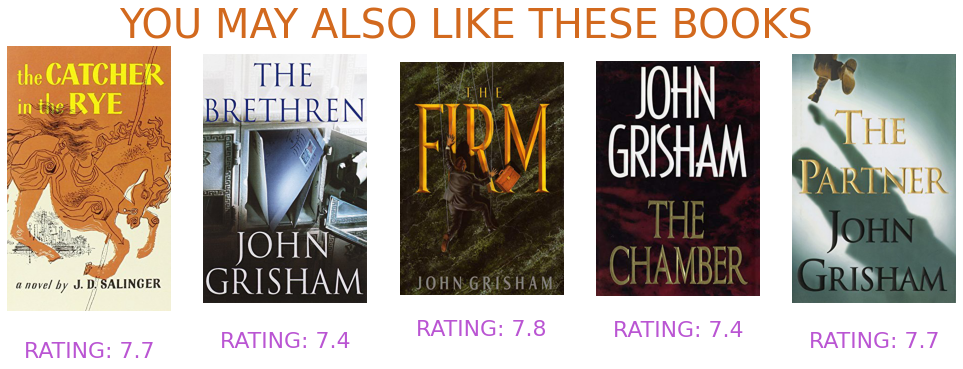

In [ ]:
content_based("The Da Vinci Code")

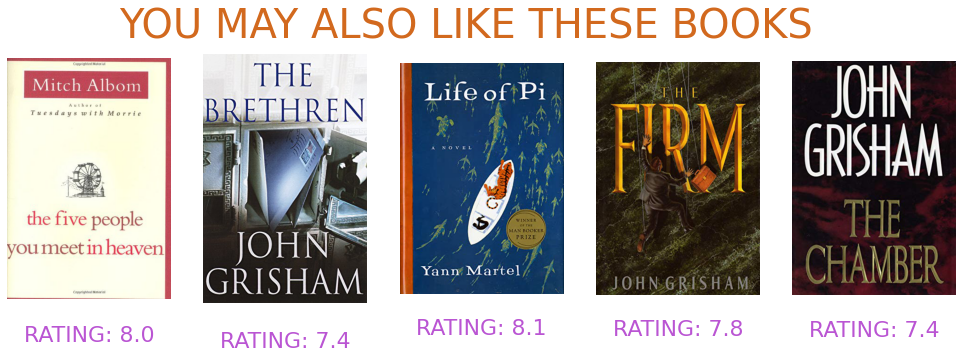

In [ ]:
content_based("Tuesdays with Morrie An Old Man a Young Man and Life s Greatest Lesson")

In [ ]:
content_based("A Soldier of the Great War")

No Recommendations for this Book ☹️ 
 
YOU MAY TRY: 
 
Harry Potter and the Chamber of Secrets Book 2 

Harry Potter and the Order of the Phoenix Book 5 

Snow Falling on Cedars 



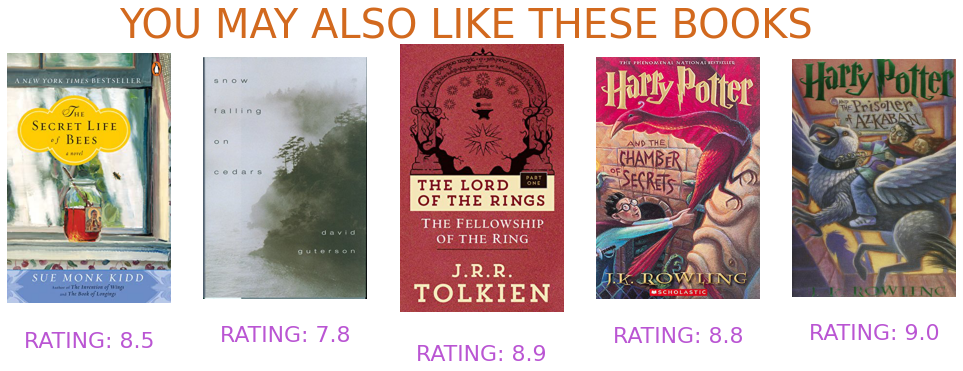

In [ ]:
content_based("Life of Pi")